In [1]:
import pandas as pd
import math
import numpy as np
import random
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## MEBF

In [2]:
def matrix_product(a,b):
    # follow online instruction of binary matrix production
    # https://www2.math.upenn.edu/~deturck/m170/wk8/lecture/matrix.html
    x = np.zeros([a.shape[0],b.shape[1]])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            sum = 0
            for k in range(b.shape[0]):
                sum += (a[i,k]*b[k,j])
            x[i,j] = sum % 2
    return x

In [3]:
def matrix_product_paper(a,b):
    x = np.zeros([a.shape[0],b.shape[1]])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            for k in range(a.shape[1]):
                if (a[i,k] or b[k,j]) == 1:
                    tmp = 1
                    break;
                else:
                    tmp = 0
            x[i,j] = tmp
    return x

In [4]:
def matrix_subtract(a,b):
    """
    parameter:
        a, of shape m*n
        b, of shape m*n
    return:
        res, of shape m*n
    """
    res = np.zeros(a.shape)
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            res[i][j] = int((a[i][j] and (not b[i][j])) or ((not a[i][j]) and b[i][j]))
    return res

In [5]:
def reconstruct(x,d,e,f,g):
    # reconstruct matrix based on cols
    col_df_1 = pd.DataFrame(d.reshape(-1,1), index =x.index) # m x 1 matrix, samples
    col_df_2 = pd.DataFrame(np.array(e).reshape(1,-1), columns = x.columns) # 1 x n matrix, features
    col_df_1.sort_index(axis = 0, inplace=True)
    col_df_2.sort_index(axis = 1, inplace=True)
    # reconstruct matrix based on rows
    row_df_1 = pd.DataFrame(np.array(g).reshape(-1,1),index = x.index)
    row_df_2 = pd.DataFrame(f.reshape(1,-1),columns = x.columns)
    row_df_1.sort_index(axis = 0, inplace=True)
    row_df_2.sort_index(axis = 1, inplace=True)
    # col pattern production
    col_pattern = matrix_product(col_df_1.values, col_df_2.values)
    # row pattern production
    row_pattern = matrix_product(row_df_1.values, row_df_2.values)
    return col_pattern, row_pattern, col_df_1, col_df_2, row_df_1, row_df_2

In [6]:
def bi_growth(x, t=0.9):
    """
    parameter: 
        x, the input Binary Matrix
        t, the threshold of vector similarity
    output:
        (a,b):
            a: list of rows(columns) of high similarity with b
            b: median row(column) of x
    """
    # UTL operation on X
    # drop columns and rows with all zeros
    x = x.loc[(x!=0).any(axis=1)]
    x = x.loc[:, (x != 0).any(axis=0)]
    # reorder based on idea in MEBF paper
    idx = x.eq(1).sum(axis=1).sort_values(ascending=False).index
    x = x.reindex(idx)
    cols = x.eq(1).sum(axis=0).sort_values(ascending=True).index
    x = x[cols]
    # d represents the median column of x
    med_col = len(x.columns) // 2
    # d = x[med_col].values
    d = x.values[:,med_col]
    # f represents the median row of x
    med_row = len(x.index) // 2
    # f = x.loc[med_row].values
    f=x.values[med_row,:]
    # iterate over each column and compute similarity
    e = []
    for col in x.columns:
        if (np.dot(x[col].values, d) / np.dot(d,d)) >= t:
            e.append(1)
        else:
            e.append(0)
    # iterate over each column and compute similarity
    g = []
    for row in x.index:
        if (np.dot(x.loc[row].values, f) / np.dot(f,f)) >= t:
            g.append(1)
        else:
            g.append(0)
    # reconstruct the approximation matrix based on rows and cols
    col_pattern, row_pattern,col_df_1,col_df_2,row_df_1,row_df_2 = reconstruct(x,d,e,f,g)
    # sort rows and columns
    x.sort_index(axis = 0,inplace=True)
    x.sort_index(axis = 1,inplace=True)
    # compute residule
    col_residule = sum(matrix_subtract(x.values, col_pattern)).sum()
    row_residule = sum(matrix_subtract(x.values, row_pattern)).sum()
    # compare cost
    if col_residule< row_residule:
        # col pattern is better
        return col_df_1, col_df_2
    else:
        # row pattern is better
        return row_df_1,row_df_2

In [7]:
def vector_and_op(a,b):
    res = list()
    for val in zip(a,b):
        if(val[0] and val[1]):
            res.append(1)
        else:
            res.append(0)
    return np.array(res).reshape(a.shape)

In [8]:
def weak_signal_detection(x,t=0.9):
    # UTL operation on X
    # drop columns and rows with all zeros
    x = x.loc[(x!=0).any(axis=1)]
    x = x.loc[:, (x != 0).any(axis=0)]
    # UTL operation on X
    idx = x.eq(1).sum(axis=1).sort_values(ascending=False).index
    x = x.reindex(idx)
    cols = x.eq(1).sum(axis=0).sort_values(ascending=True).index
    x = x[cols]
    # compute d_1
    d_1 = vector_and_op(x.values[:,-2],x.values[:,-1])
    # iterate over each column and compute similarity, filter cols
    e_1 = []
    for col in x.columns:
        if (np.dot(x[col].values, d_1) / np.dot(d_1,d_1)) >= t:
            e_1.append(1)
        else:
            e_1.append(0)
    # iterate over each column and compute similarity, filter rows
    d_2 = vector_and_op(x.values[0,:],x.values[1,:])
    e_2 = []
    for row in x.index:
        if (np.dot(x.loc[row].values, d_2) / np.dot(d_2,d_2)) >= t:
            e_2.append(1)
        else:
            e_2.append(0)
    # reconstruct the approximation matrix based on rows and cols
    pattern_1, pattern_2, l1_1,l1_2,l2_1,l2_2 = reconstruct(x,d_1,e_1,d_2,e_2)
    # sort by index and columns
    x.sort_index(axis = 0,inplace=True)
    x.sort_index(axis = 1,inplace=True)
    # compute residule
    l1 = matrix_subtract(x.values, pattern_1)
    l2 = matrix_subtract(x.values, pattern_2)
     # compare cost
    if sum(l1).sum() < sum(l2).sum():
        return l1_1,l1_2
    else:
        return l2_1,l2_2

In [9]:
def MEBF(x,t=0.8):
    # re_A, re_B to record the pattern
    re_A = pd.DataFrame(index =x.index.values)
    re_B = pd.DataFrame(columns = x.columns.values)
    cost = float('inf')
    x_residule = x.copy()
    while True:
        new_1, new_2 = bi_growth(x_residule,t)
        # check whether new pattern could fit better
        A_tmp = pd.concat([re_A,new_1],axis = 1).fillna(0)
        B_tmp = pd.concat([re_B,new_2],axis = 0).fillna(0)
        tmp_residule = matrix_subtract(x.values,matrix_product(A_tmp.values,B_tmp.values))
        if sum(tmp_residule).sum() > cost:
            # weak signal detection
            l1,l2 = weak_signal_detection(x_residule,t)
            A_tmp = pd.concat([re_A,l1],axis = 1).fillna(0)
            B_tmp = pd.concat([re_B,l2],axis = 0).fillna(0)
            tmp_residule = matrix_subtract(x.values,matrix_product(A_tmp.values,B_tmp.values))
            print("weak detection")
            print("old cost", cost)
            print("new cost", sum(tmp_residule).sum())
            if sum(tmp_residule).sum() >= cost:
                print("no more pattern, break")
                break
        # update re_A, re_B, and cost
        re_A = A_tmp.copy()
        re_B = B_tmp.copy()
        cost = sum(tmp_residule).sum()
        # update x_residule
        tmp = pd.DataFrame(matrix_product(new_1.values,new_2.values), index = new_1.index, columns = new_2.columns)
        for i in tmp.index:
            for j in tmp.columns:
                if(tmp.loc[i][j] == 1):
                    x_residule.loc[i][j] = 0
        if sum(x_residule.values).sum() == 0:
            break
    return re_A, re_B

In [10]:
x_in_paper = pd.DataFrame(np.array([[1,1,0,1,1,1,0,1,0,0,0],[1,1,1,1,1,1,1,1,1,1,1],[1,1,0,1,1,1,1,0,1,0,1],
         [0,1,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,0,0],[1,1,1,1,1,1,1,0,1,0,0],
         [0,0,0,1,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1,0],[1,1,0,1,0,1,1,0,0,0,0],
         [1,1,1,1,1,0,0,0,0,0,0,],[1,1,0,1,1,0,0,0,0,0,0]]), index = range(1,12), columns = range(1,12))
A,B = MEBF(x_in_paper,0.8)

In [12]:
x = x_in_paper.copy()

In [13]:
    re_A = pd.DataFrame(index =x.index.values)
    re_B = pd.DataFrame(columns = x.columns.values)
    cost = float('inf')
    x_residule = x.copy()

In [16]:
        new_1, new_2 = bi_growth(x_residule,t)
        # check whether new pattern could fit better
        A_tmp = pd.concat([re_A,new_1],axis = 1).fillna(0)
        B_tmp = pd.concat([re_B,new_2],axis = 0).fillna(0)
        tmp_residule = matrix_subtract(x.values,matrix_product(A_tmp.values,B_tmp.values))

In [17]:
        re_A = A_tmp.copy()
        re_B = B_tmp.copy()
        cost = sum(tmp_residule).sum()
        # update x_residule
        tmp = pd.DataFrame(matrix_product(new_1.values,new_2.values), index = new_1.index, columns = new_2.columns)
        for i in tmp.index:
            for j in tmp.columns:
                if(tmp.loc[i][j] == 1):
                    x_residule.loc[i][j] = 0

In [20]:
x = x_residule.copy()

In [22]:
x

,1,2,3,4,5,6,8,10,11
1,1,1,0,1,1,1,1,0,0
2,0,0,1,0,0,0,1,1,1
3,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0
5,0,0,1,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0
8,0,0,1,0,0,0,1,1,0
10,1,1,1,1,1,0,0,0,0
11,1,1,0,1,1,0,0,0,0


In [23]:
    idx = x.eq(1).sum(axis=1).sort_values(ascending=False).index
    x = x.reindex(idx)
    cols = x.eq(1).sum(axis=0).sort_values(ascending=True).index
    x = x[cols]

In [42]:
x = x[[6,10,11,5,1,8,2,4,3]]

In [43]:
x = x.reindex([1,2,11,10,8,5,3,6,7,4])

In [53]:
x.shape[0]//2

5

In [55]:
x

,6,10,11,5,1,8,2,4,3
1,1,0,0,1,1,1,1,1,0
2,0,1,1,0,0,1,0,0,1
11,0,0,0,1,1,0,1,1,0
10,0,0,0,1,1,0,1,1,1
8,0,1,0,0,0,1,0,0,1
5,0,0,0,0,0,1,0,0,1
3,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0


In [54]:
x.values[5,:]

array([0, 0, 0, 0, 0, 1, 0, 0, 1])

In [ ]:
def bi_growth(x, t=0.9):
    """
    parameter: 
        x, the input Binary Matrix
        t, the threshold of vector similarity
    output:
        (a,b):
            a: list of rows(columns) of high similarity with b
            b: median row(column) of x
    """
    # UTL operation on X
    # drop columns and rows with all zeros
    x = x.loc[(x!=0).any(axis=1)]
    x = x.loc[:, (x != 0).any(axis=0)]
    # reorder based on idea in MEBF paper
    idx = x.eq(1).sum(axis=1).sort_values(ascending=False).index
    x = x.reindex(idx)
    cols = x.eq(1).sum(axis=0).sort_values(ascending=True).index
    x = x[cols]
    # d represents the median column of x
    med_col = len(x.columns) // 2
    # d = x[med_col].values
    d = x.values[:,med_col]
    # f represents the median row of x
    med_row = len(x.index) // 2
    # f = x.loc[med_row].values
    f=x.values[med_row,:]
    # iterate over each column and compute similarity
    e = []
    for col in x.columns:
        if (np.dot(x[col].values, d) / np.dot(d,d)) >= t:
            e.append(1)
        else:
            e.append(0)
    # iterate over each column and compute similarity
    g = []
    for row in x.index:
        if (np.dot(x.loc[row].values, f) / np.dot(f,f)) >= t:
            g.append(1)
        else:
            g.append(0)
    # reconstruct the approximation matrix based on rows and cols
    col_pattern, row_pattern,col_df_1,col_df_2,row_df_1,row_df_2 = reconstruct(x,d,e,f,g)
    # sort rows and columns
    x.sort_index(axis = 0,inplace=True)
    x.sort_index(axis = 1,inplace=True)
    # compute residule
    col_residule = sum(matrix_subtract(x.values, col_pattern)).sum()
    row_residule = sum(matrix_subtract(x.values, row_pattern)).sum()
    # compare cost
    if col_residule< row_residule:
        # col pattern is better
        return col_df_1, col_df_2
    else:
        # row pattern is better
        return row_df_1,row_df_2

<AxesSubplot:>

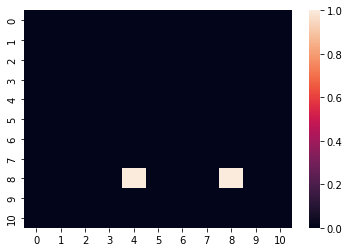

In [261]:
sns.heatmap(matrix_subtract(x_in_paper.values, matrix_product(A.values, B.values)), annot=False, vmin=0, vmax=1)

In [262]:
# try BMF on our data
t1 = data_res.copy()
t1[t1>0.5] = 1
t1[t1<-0.5] = 1
t1[t1!=1] =0
t2 = data_res.copy()
t2[t1>0.25] = 1
t2[t1<-0.25] = 1
t2[t1!=1] =0

In [263]:
A1,B1 = MEBF(t1,0.8)
A2,B2 = MEBF(t2,0.8)

<AxesSubplot:>

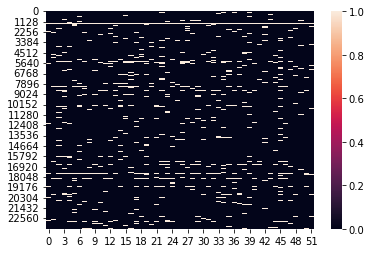

In [273]:
sns.heatmap(A1.values, annot=False, vmin=0, vmax=1)

<AxesSubplot:>

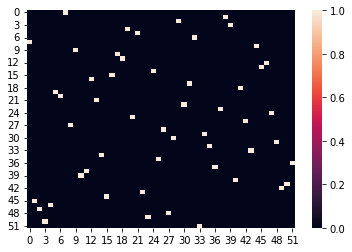

In [274]:
sns.heatmap(B1.values, annot=False, vmin=0, vmax=1)

In [277]:
sum(matrix_subtract(t1.values, matrix_product(A1.values, B1.values))).sum(),sum(matrix_subtract(t2.values, matrix_product(A2.values, B2.values))).sum()

(0.0, 0.0)

### Perfectly fit. But the process is kind of random.